<a href="https://colab.research.google.com/github/elianedp/ExpertSystem/blob/main/Comp_Natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATIVIDADE SOMATIVA 2 - ALGORITMO DE COLÔNIA DE FORMIGAS
# Este código foi modificado para atender aos requisitos da atividade:
# - Questão 1: Novo mapa e 10 pontos de interesse definidos com coordenadas corretas.
# - Questão 2: Alteração do parâmetro 'pheromone_power'.
# - Questão 3: Alteração do parâmetro 'ant_count'.


In [23]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:

import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

random.seed(42)
np.random.seed(42)


In [25]:
#Célula 2 — Mapa & Pontos (Q1)

# CARREGAMENTO DO MAPA E DEFINIÇÃO DOS PONTOS DE INTERESSE

# Carrega a imagem do mapa (mantido o mesmo caminho e mesmas coordenadas)
foz_map = mpimg.imread("/content/drive/MyDrive/mapafoz/MAP_PATH_1_FOZ.jpg")

try:
    h, w = foz_map.shape[0], foz_map.shape[1]
    print("Dimensões do mapa (largura x altura):", w, "x", h)
except Exception:
    pass

# 10 pontos com coordenadas ajustadas para o mapa
places = {
    "Cataratas do Iguaçu": (1150, 600),
    "Marco das Três Fronteiras": (890, 560),
    "Usina de Itaipu": (350, 190),
    "Mesquita Muçulmana": (600, 300),
    "Templo Budista": (580, 100),
    "Parque das Aves": (1100, 580),
    "Shopping JL Cataratas": (700, 390),
    "Aeroporto de Foz": (1180, 510),
    "Cidade do Leste": (300, 350),
    "Puerto Iguazú": (800, 580)
}
# Transforma em lista ordenada (ordem alfabética) para uso no algoritmo
places = list(sorted(places.items()))
print(f"Total de pontos definidos: {len(places)}")

Dimensões do mapa (largura x altura): 1300 x 676
Total de pontos definidos: 10


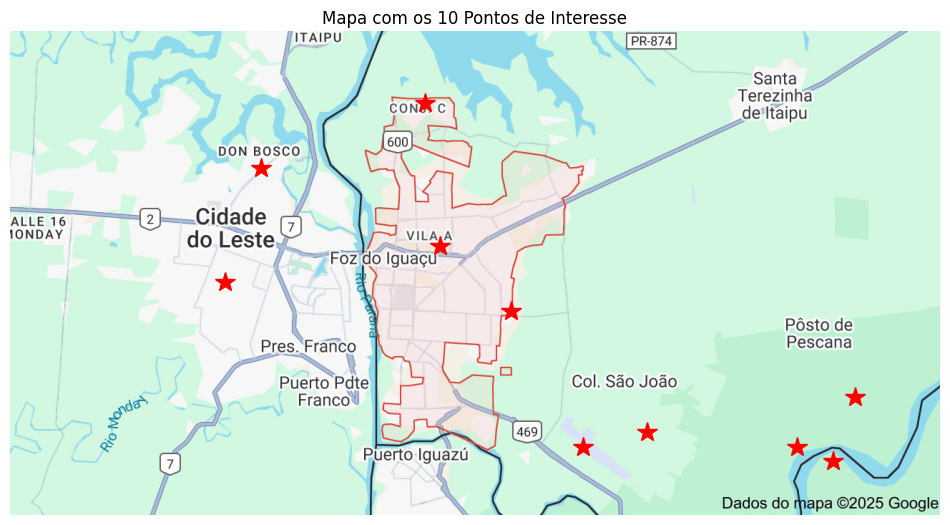

In [26]:
#Célula 3 — Visualização (funções) + Plot Q1

# Visualiza os 10 pontos no mapa
def show_cities(path, w=12, h=8, savepath=None):
    if isinstance(path, dict):
        path = list(path.values())
    if isinstance(path[0][0], str):
        path = [item[1] for item in path]
    plt.imshow(foz_map)
    for x0, y0 in path:
        plt.plot(x0, y0, 'r*', markersize=15)  # r* = estrela vermelha para os pontos
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    plt.title("Mapa com os 10 Pontos de Interesse")
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()

def show_path(path, starting_city=None, w=12, h=8, savepath=None):
    if isinstance(path, dict):
        path = list(path.values())
    if isinstance(path[0][0], str):
        path = [item[1] for item in path]
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    (x0, y0) = starting_city
    plt.imshow(foz_map)
    plt.plot(x + x[:1], y + y[:1])
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    plt.title("Rota Otimizada do Caixeiro-Viajante")
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()

show_cities(places, savepath="q1_pontos.png")


In [28]:
#Célula 4 — Utilitários (distância, custo, polyfit )

def polyfit_plot(x, y, deg, **kwargs):
    coefficients = np.polyfit(x, y, deg, **kwargs)
    poly = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0] - 1, x[-1] + 1])
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c, 1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^' + str(p)
        terms.append(term)
    plt.title(" + ".join(reversed(terms)))

def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str):
        xy1 = xy1[1]; xy2 = xy2[1]
    return math.sqrt((xy1[0] - xy2[0])**2 + (xy1[1] - xy2[1])**2)

def path_distance(path) -> int:
    if isinstance(path, dict):
        path = list(path.values())
    if isinstance(path[0][0], str):
        path = [item[1] for item in path]
    return int(sum(
        [distance(path[i], path[i + 1]) for i in range(len(path) - 1)]
        + [distance(path[-1], path[0])]
    ))

In [29]:
#Célula 5 — Classe ACO (completa)

# CLASSE E FUNÇÕES DO

class AntColonySolver:
    def __init__(self,
                 cost_fn: Callable[[Any, Any], Union[float, int]],
                 time=0,
                 min_time=0,
                 timeout=0,
                 stop_factor=2,
                 min_round_trips=10,
                 max_round_trips=0,
                 min_ants=0,
                 max_ants=0,
                 ant_count=64,
                 ant_speed=1,
                 distance_power=1,
                 pheromone_power=1.25,
                 decay_power=0,
                 reward_power=0,
                 best_path_smell=2,
                 start_smell=0,
                 verbose=False,
    ):
        assert callable(cost_fn)
        self.cost_fn = cost_fn
        self.time = int(time)
        self.min_time = int(min_time)
        self.timeout = int(timeout)
        self.stop_factor = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants = int(min_ants)
        self.max_ants = int(max_ants)
        self.ant_count = int(ant_count)
        self.ant_speed = int(ant_speed)
        self.distance_power = float(distance_power)
        self.pheromone_power = float(pheromone_power)
        self.decay_power = float(decay_power)
        self.reward_power = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell = float(start_smell or 10**self.distance_power)
        self.verbose = int(verbose)
        self._initalized = False
        if self.min_round_trips and self.max_round_trips:
            self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:
            self.min_ants = min(self.min_ants, self.max_ants)

    def solve_initialize(self, problem_path: List[Any]) -> None:
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }
        self.pheromones = {
            source: {
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[d.values() for d in self.distances.values()]))) // 5
        self.ant_speed = int(max(1, self.ant_speed))

        self.ants_used = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True

    def solve(self, problem_path: List[Any], restart=False) -> List[Tuple[int, int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ants = {
            "distance": np.zeros((self.ant_count,)).astype('int32'),
            "path": [[problem_path[0]] for _ in range(self.ant_count)],
            "remaining": [set(problem_path[1:]) for _ in range(self.ant_count)],
            "path_cost": np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path = None
        best_path_cost = np.inf
        best_epochs = []
        epoch = 0
        time_start = time.perf_counter()

        while True:
            epoch += 1

            # Ants moving
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ants_travelling] -= self.ant_speed
            if all(ants_travelling):
                continue

            # Ants arrived (or ready to move)
            ants_arriving = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]

            for i in ants_arriving_index:
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)

                ants['distance'][i] = self.distances[this_node][next_node]

                # >>> Correção: remover o nó de destino da lista de 'restantes'
                ants['remaining'][i].discard(next_node)

                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append(next_node)

                # Fechou o ciclo? (voltou ao início e não há mais nós a visitar)
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path = True
                        best_path_cost = ants['path_cost'][i]
                        best_path = ants['path'][i]
                        best_epochs += [epoch]
                        if self.verbose:
                            print({
                                "path_cost": int(ants['path_cost'][i]),
                                "ants_used": self.ants_used,
                                "epoch": epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock": int(time.perf_counter() - time_start),
                            })

                    reward = 1
                    if self.reward_power:
                        reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:
                        reward *= (self.round_trips ** self.decay_power)

                    for path_index in range(len(ants['path'][i]) - 1):
                        a = ants['path'][i][path_index]
                        b = ants['path'][i][path_index + 1]
                        self.pheromones[a][b] += reward
                        self.pheromones[b][a] += reward
                        if was_best_path:
                            self.pheromones[a][b] *= self.best_path_smell
                            self.pheromones[b][a] *= self.best_path_smell

                    # Reset dessa formiga para nova rodada
                    ants["distance"][i] = 0
                    ants["path"][i] = [problem_path[0]]
                    ants["remaining"][i] = set(problem_path[1:])
                    ants["path_cost"][i] = 0
                    ants["round_trips"][i] += 1

            if not len(best_epochs):
                continue

            # Critérios de parada
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time:
                        break
                    else:
                        continue
                if self.min_time and clock < self.min_time:
                    continue
                if self.timeout and clock > self.timeout:
                    break

            if self.min_round_trips and self.round_trips < self.min_round_trips:
                continue
            if self.max_round_trips and self.round_trips >= self.max_round_trips:
                break
            if self.min_ants and self.ants_used < self.min_ants:
                continue
            if self.max_ants and self.ants_used >= self.max_ants:
                break
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor):
                break

            if True:
                continue

        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path

    def next_node(self, ants, index):
        this_node = ants['path'][index][-1]

        if not ants['remaining'][index]:
            # se acabou, retornar à origem
            return ants['path'][index][0]

        weights = []
        weights_sum = 0.0

        for nxt in ants['remaining'][index]:
            if nxt == this_node:
                continue
            reward = (
                self.pheromones[this_node][nxt] ** self.pheromone_power
                * self.distance_cost[this_node][nxt]
            )
            weights.append((reward, nxt))
            weights_sum += reward

        rand = random.random() * weights_sum
        for (weight, nxt) in weights:
            if rand > weight:
                rand -= weight
            else:
                return nxt

        # fallback (não deveria acontecer)
        return weights[-1][1]


In [31]:
#Célula 6 — Runner

def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, savepath=None, **kwargs):
    solver = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result = solver.solve(cities)
    stop_time = time.perf_counter()

    if label:
        kwargs = {**label, **kwargs}
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs:
            del kwargs[key]

    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | ".format(
        len(cities), path_distance(cities), path_distance(result), (stop_time - start_time),
        solver.ants_used, solver.round_trips
    ) + " ".join([f"{k}={v}" for k, v in kwargs.items()]))

    if plot:
        show_path(result, savepath=savepath)

    return result

==> Questão 2: Comparação com diferentes valores para 'pheromone_power'

--- Execução 1: Valor Padrão (pheromone_power = 1.25) ---
{'path_cost': 2828, 'ants_used': 1, 'epoch': 1940, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 2706, 'ants_used': 2, 'epoch': 1981, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 2374, 'ants_used': 3, 'epoch': 2081, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 2356, 'ants_used': 5, 'epoch': 2251, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 2301, 'ants_used': 65, 'epoch': 3889, 'round_trips': np.int32(2), 'clock': 0}
{'path_cost': 2240, 'ants_used': 73, 'epoch': 4359, 'round_trips': np.int32(2), 'clock': 0}
N=10  |  4534 -> 2246 |    0s | ants:   522 | trips:   10 | pheromone_power=1.25


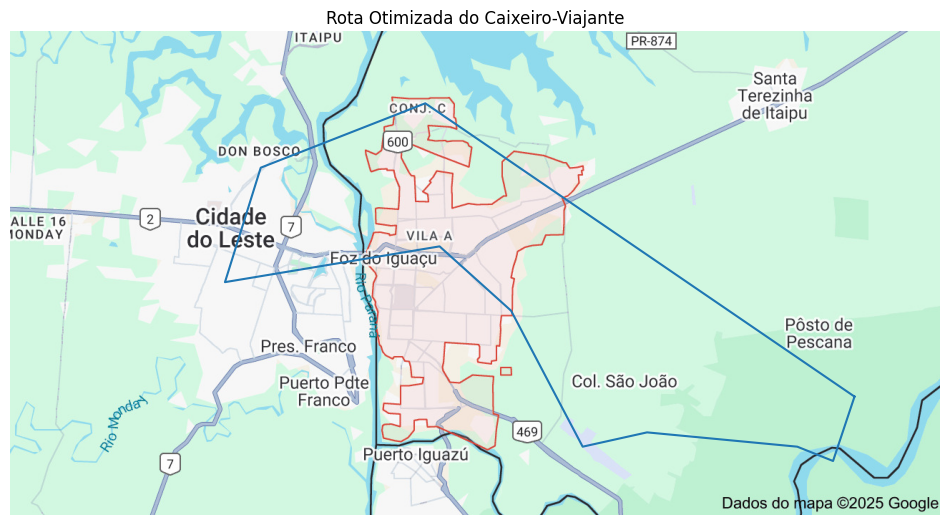


--- Execução 2: Valor Alterado (pheromone_power = 2.5) ---
{'path_cost': 2475, 'ants_used': 1, 'epoch': 1860, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 2436, 'ants_used': 2, 'epoch': 1943, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 2240, 'ants_used': 65, 'epoch': 3859, 'round_trips': np.int32(2), 'clock': 0}
N=10  |  4534 -> 2247 |    0s | ants:   555 | trips:   10 | pheromone_power=2.5


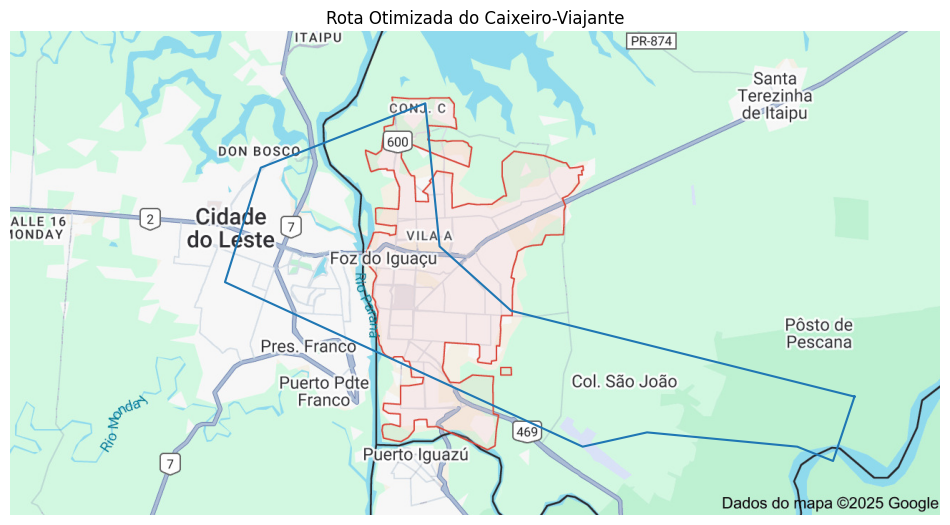

In [42]:
# Q2 — Comparação de 'pheromone_power' (padrão vs alterado)
print("==> Questão 2: Comparação com diferentes valores para 'pheromone_power'")

print("\n--- Execução 1: Valor Padrão (pheromone_power = 1.25) ---")
results_default = AntColonyRunner(
    places, verbose=True, plot=True, pheromone_power=1.25, savepath="q2_p1_pheromone_1.25.png"
)

print("\n--- Execução 2: Valor Alterado (pheromone_power = 2.5) ---")
results_mod_1 = AntColonyRunner(
    places, verbose=True, plot=True, pheromone_power=2.5, savepath="q2_p2_pheromone_2.5.png"
)


------------------------------------------------------------------
==> Questão 3: Alteração de um segundo parâmetro ('ant_count')

--- Execução 3: Pheromone Power (2.5) e Ant Count (100) ---
{'path_cost': 2309, 'ants_used': 1, 'epoch': 1694, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 2292, 'ants_used': 5, 'epoch': 1999, 'round_trips': np.int32(1), 'clock': 0}
N=10  |  4534 -> 2298 |    0s | ants:   111 | trips:    2 | pheromone_power=2.5 ant_count=100 timeout=25 min_round_trips=1 stop_factor=2


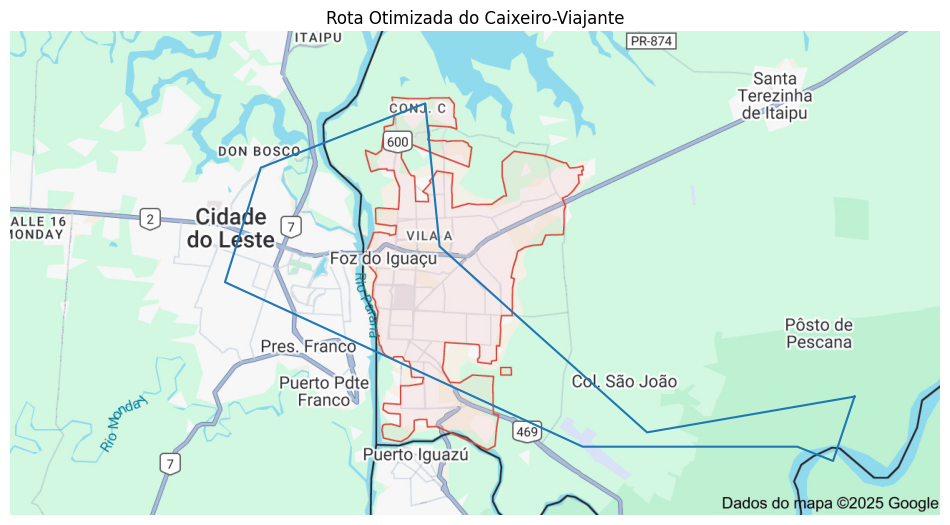


------------------------------------------------------------------
EXECUÇÃO CONCLUÍDA
------------------------------------------------------------------


In [44]:
#Célula 10 — Q3 (ant_count)
# Questão 3: Alteração de um segundo parâmetro (ant_count)
LINE = "-" * 66

print("\n" + LINE)
print("==> Questão 3: Alteração de um segundo parâmetro ('ant_count')")
print("\n--- Execução 3: Pheromone Power (2.5) e Ant Count (100) ---")

results_mod_2 = AntColonyRunner(
    places,
    verbose=True,
    plot=True,
    pheromone_power=2.5,
    ant_count=100,
    timeout=25,          # garante término
    min_round_trips=1,   # ao menos 1 volta completa
    stop_factor=2        # encerra quando parar de melhorar
)

print("\n" + LINE)
print("EXECUÇÃO CONCLUÍDA")
print(LINE)